## In this assignment, we will get acquainted with essential matrix and fundamental matrix. And recover the essential matrix from matched points of two scene with OpenCV. Furthermore, we will try to localize these matched points in the 3D space


In [1]:
# Read matched points from two scenes

import pickle
with open('data_points.pickle','rb') as handle:
    data=pickle.load(handle)

In [2]:
# Find fundamental matrix from the match points using OpenCV
import cv2

pts1 = data['x1']
pts2 = data['x2']

F, mask = cv2.findFundamentalMat(pts1,pts2,cv2.FM_8POINT)
pts1 = pts1[mask.ravel()==1] # remove outliers by only keeping inliers
pts2 = pts2[mask.ravel()==1] # 

In [3]:
# "Find" essential matrix
import numpy as np

K = np.eye(3) # Take the camera intrisic matrix matrix K to be identity. 
E = K.T @ F @ K # The essential matrix is just the same as the fundamental matrix when K = I

#E, mask = cv2.findEssentialMat(pts1,pts2,K,cv2.RANSAC) # alternatively, we may try to find essential matrix directly

In [4]:
# Sanity check of the essential matrix
import numpy as np

hx1=np.hstack((pts1,np.ones((2000,1))))
hx2=np.hstack((pts2,np.ones((2000,1))))

rint=np.random.randint(hx1.shape[0])
hx2[rint].T @ E @hx1[rint] # this should be almost zero

7.94919907676217e-10

# Q1 (5 points) Compute a potential solution of R and t from E. Note that you will only get half of the points if you use cv2.decomposeEssentialMat

In [8]:
import numpy as np

# this function should be helpful. You probably want to call the function below instead of np.linalg.svd
def mySVD(E): # compute SVD E = U S V and enforcing det(U)=det(V)=1
    U,S,V = np.linalg.svd(E)
    detU=np.linalg.det(U)
    detV=np.linalg.det(V)
    U=U/detU
    V=V/detV
    S=S*detU*detV
    return U,S,V

def compute_one_R_and_t_from_E(E):
    # Input:
        # E: essential matrix
    # Output:
        # R: rotation matrix (3x3)
        # t: translation (3x1)
    W = np.array([[0,-1,0],
                  [1,0,0],
                  [0,0,1]])
    #from Simon J. D Prince CV Text book equations 16.18 and 16.19
    #U, L, VT = np.linalg.svd(E)
    #tx = U @ np.diag(L) @ W @ np.transpose(U)
    #t = np.transpose(np.array([tx[2,1],tx[0,2],tx[1,0]]))
    #R = U @ np.linalg.inv(W) @ (VT)
    
    #from slides
    U, S, VT = mySVD(E)
    tx = np.transpose(VT) @ W @ np.diag(S) @ VT
    t = np.transpose(np.array([((tx[1,2]-tx[2,1])/2),((tx[2,0]-tx[0,2])/2),((tx[0,1]-tx[1,0])/2)]))
    R = U @ np.transpose(W) @ VT
    
    return R,t



## Testing solution of Q.1

In [9]:
R,t = compute_one_R_and_t_from_E(E)

tx= np.array([[0,t[2],-t[1]],
              [-t[2],0,t[0]],
              [t[1],-t[0],0]])
R@tx-E

array([[-1.03683028e-06,  1.28662268e-05,  1.28662304e-05],
       [-1.28662298e-05, -5.18415111e-07, -5.18415249e-07],
       [ 1.28662273e-05,  5.18415023e-07,  5.18415160e-07]])

# Q2.a (5 points) For two lines ${\bf a_1} + \lambda_1 {\bf b_1}$ and ${\bf a_2} + \lambda_2 {\bf b_2}$ in the 3-D space parametrized by $\lambda_1$ and $\lambda_2$ (${\bf a_1}, {\bf a_2}, {\bf b_1}, {\bf b_2}$ are length-$3$ vectors). Find the intersecting point between the two lines (the mid point between the closest points of the two lines) by derivating the expressions of the optimum $\lambda_1$ and $\lambda_2$.

(<AxesSubplot:title={'center':'Part 2'}>,
 Text(0.5, 1.0, 'Part 2'),
 ([], []),
 ([], []))

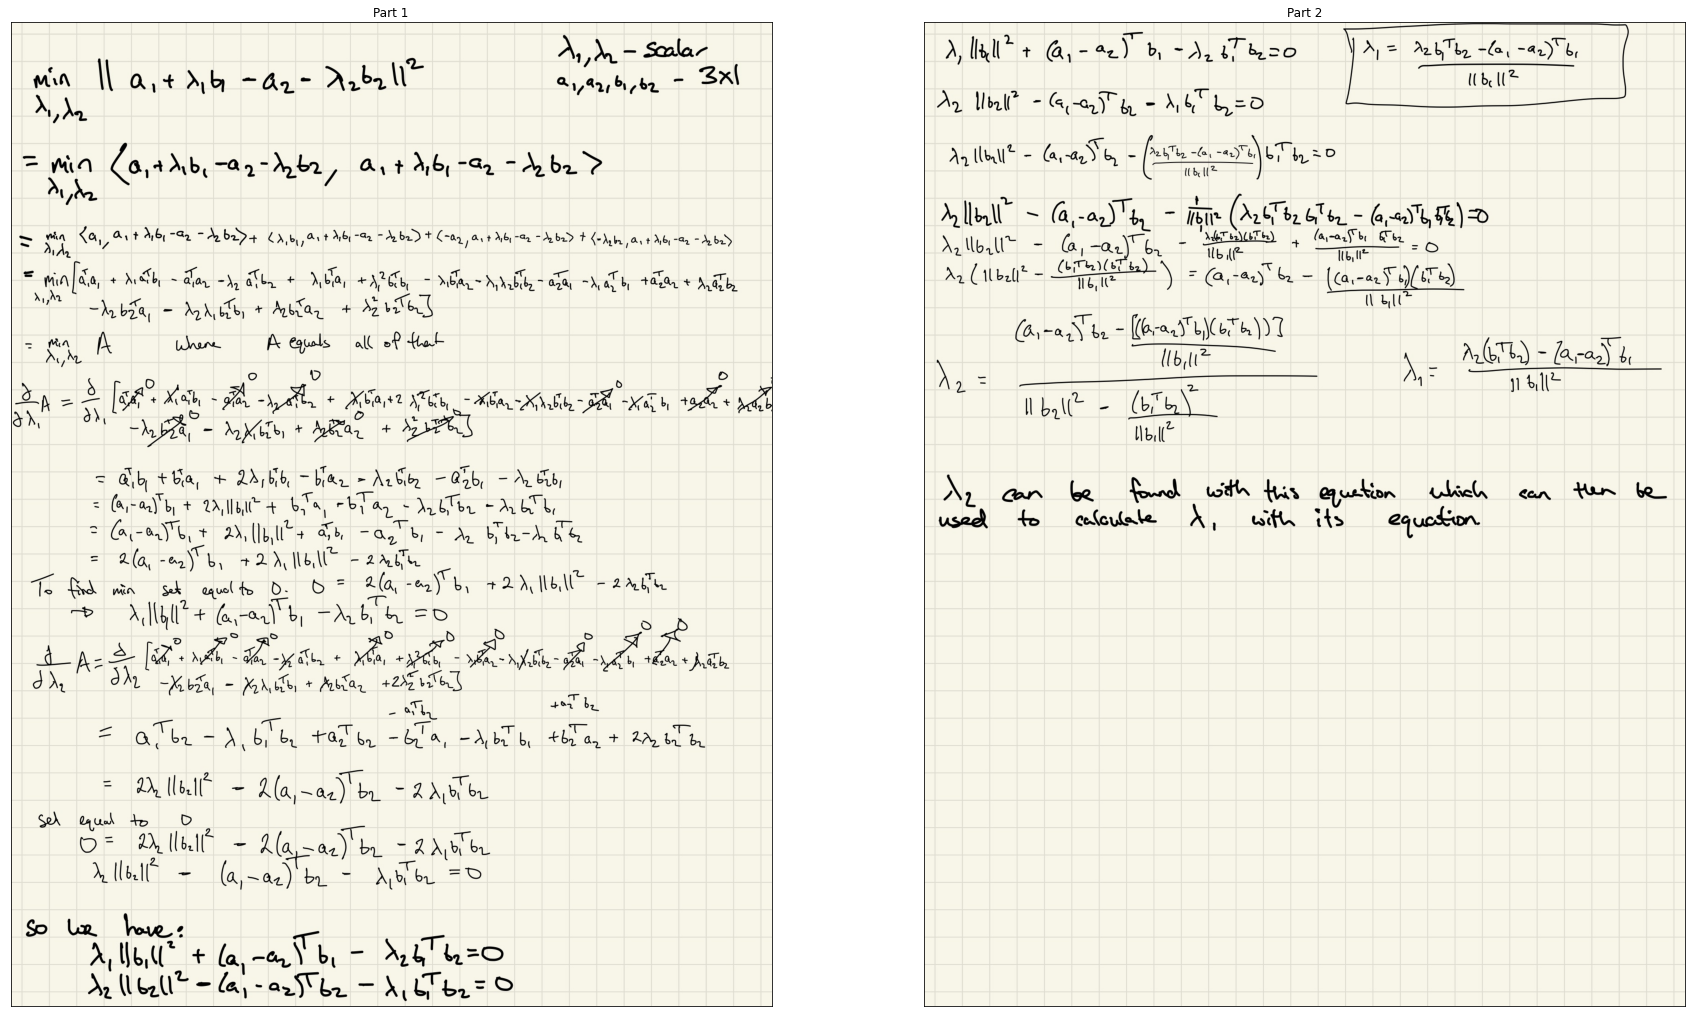

In [17]:
from matplotlib import pyplot as plt
import cvui
%matplotlib inline

math1 = cv2.imread('2a-1.jpg')
math1 = cv2.cvtColor(math1, cv2.COLOR_BGR2RGB)
math2 = cv2.imread('2a-2.jpg')
math2 = cv2.cvtColor(math2, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(30,30))
plt.subplot(121), plt.imshow(math1), plt.title("Part 1"), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(math2), plt.title("Part 2"), plt.xticks([]), plt.yticks([])

# Q2.b (5 points) Implement the solution of Q2.a by completing the function below



In [103]:
def computeIntersection(a1,b1,a2,b2):
    # Input:
        # a1: Nx3 matrix  (a1[i] = ith a1)
        # b1: Nx3 matrix  (b1[i] = ith b1)
        # a2: Nx3 matrix  (a2[i] = ith a2)
        # b2: Nx3 matrix  (b2[i] = ith b2)
        # N.B. for the ith pair of lines, line 1: a1[i]+lambda1[i] b1[i] and line 2: a2[i]+lambda2[i] b2[i]
    # Output:
        # points: Nx3 matrix (points[i] = the intersecting point for ith pair)
    points = []
    
    n = len(a1)
    for i in range(n):
        a1i = a1[i]
        a2i = a2[i]
        b1i = b1[i]
        b2i = b2[i]
        b1t = np.transpose(b1i)
        b2t = np.transpose(b2i)
        a1t = np.transpose(a1i)
        a2t = np.transpose(a2i)
        b1normsq = (b1i @ b1t) * (b1i @ b1t) 
        b2normsq = (b2i @ b2t) * (b2i @ b2t)
        a1a2t = np.transpose(a1i-a2i)
        
        lambda2 = (a1a2t@b2i - (a1a2t * b1i / (b1normsq)) * (b1i @ b2t)) / ((b2normsq - (b1i@b2t)/(b1normsq) * (b1i @b2t)))
        lambda1 = (lambda2*(b1i@b2t)-a1a2t@b1i) / ((b1normsq))
        point = (a1i + (lambda1 * b1i) + a2i + (lambda2 * b2i))/2
        points.append(point)
    return points

## Testing solution of Q2.b
#### We will take camera center of view 1 as origin, so ${\bf a_1} = {\bf 0}$, ${\bf b_1} = [x_1[0],x_1[1],1]^\top$
#### And ${\bf a_2} = {\bf t}$, $b_2 = R [x_2[0],x_2[1],0]^\top$



In [104]:
a1 = np.zeros((pts1.shape[0],3))
b1 = np.hstack((pts1,np.ones((pts1.shape[0],1))))
a2 = np.tile(t,(pts1.shape[0],1))
b2 = np.hstack((pts2,np.ones((pts2.shape[0],1))))
b2 = (R.T @ b2.T).T

Xs=computeIntersection(a1,b1,a2,b2) # 3D coordinates of points in the first camera view
Xps=(R@(Xs-t).T).T # 3D coordinates of points in the second camera view
Xs,Xps

([array([  124.0305861 ,   150.1711361 , -1074.88763031]),
  array([  149.21784288,   791.88021009, -1874.30966535]),
  array([  227.84267421,   749.33131632, -1824.49746768]),
  array([ 1126.48368707,  -140.92844413, -1230.59469645]),
  array([  328.58112004,   688.43312213, -1763.59863021]),
  array([   90.33817386,   164.7928346 , -1045.99130315]),
  array([  -58.41040778,   548.96783935, -1335.18744348]),
  array([ -236.42731009,   354.26208177, -1074.6521569 ]),
  array([   91.20596101,   798.89436637, -1888.04790886]),
  array([  654.32450126,    82.75554396, -1726.84312393]),
  array([  -22.23122339,   507.42742431, -1302.09606932]),
  array([ -143.22525912,   325.26553037, -1049.41462009]),
  array([  408.79561261,   874.52430296, -1946.41098213]),
  array([  279.10288954,   847.45413131, -1920.86608684]),
  array([  378.53056978,   775.3698783 , -1853.49068366]),
  array([  100.90595344,   961.12727238, -2055.00897403]),
  array([  355.04001113,   639.59848649, -1704.80960938]

# Chirality

### Note that Xs and Xps are the points in the 3D space with camera centers as origins and with z-axis pointing from the camera centers to the objects. So the z-component (third column of Xs and Xps) should be both non-negative because the object points suppose to be in front of the cameras. But with only 1/4 of the chance you would be lucky. Because there are four possible combinations of R and t and only one is correct (satisfies chirality).

# Q2.c (4 points) Find the correct R and t by adjusting your solution in Q1. It is okay to provide a "buggy" solution that only works for the current dataset. Please redefine compute_one_R_and_t_from_E(E) below 

In [11]:
import numpy as np

# this function should be helpful. You probably want to function below instead of np.linalg.svd
def mySVD(E): # compute SVD E = U S V and enforcing det(U)=det(V)=1
    U,S,V = np.linalg.svd(E)
    detU=np.linalg.det(U)
    detV=np.linalg.det(V)
    U=U/detU
    V=V/detV
    S=S*detU*detV
    return U,S,V

def compute_one_R_and_t_from_E(E):
    # Input:
        # E: essential matrix
    # Output:
        # R: rotation matrix (3x3)
        # t: translation (3x1)
    pass

In [13]:
# rerun everything below

R,t = compute_one_R_and_t_from_E(E)

tx= np.array([[0,t[2],-t[1]],[-t[2],0,t[0]],[t[1],-t[0],0]])
rint=np.random.randint(hx1.shape[0])
hx2[rint].T @ R@tx @hx1[rint] # this should be almost zero


6.238334793184919e-07

In [105]:
a1 = np.zeros((pts1.shape[0],3))
b1 = np.hstack((pts1,np.ones((pts1.shape[0],1))))
a2 = np.tile(t,(pts2.shape[0],1))
b2 = np.hstack((pts2,np.ones((pts2.shape[0],1))))
b2 = (R.T @ b2.T).T

Xs=computeIntersection(a1,b1,a2,b2)
Xps=(R@(Xs-t).T).T 
Xs,Xps # note that third third columns should be positive

([array([  124.0305861 ,   150.1711361 , -1074.88763031]),
  array([  149.21784288,   791.88021009, -1874.30966535]),
  array([  227.84267421,   749.33131632, -1824.49746768]),
  array([ 1126.48368707,  -140.92844413, -1230.59469645]),
  array([  328.58112004,   688.43312213, -1763.59863021]),
  array([   90.33817386,   164.7928346 , -1045.99130315]),
  array([  -58.41040778,   548.96783935, -1335.18744348]),
  array([ -236.42731009,   354.26208177, -1074.6521569 ]),
  array([   91.20596101,   798.89436637, -1888.04790886]),
  array([  654.32450126,    82.75554396, -1726.84312393]),
  array([  -22.23122339,   507.42742431, -1302.09606932]),
  array([ -143.22525912,   325.26553037, -1049.41462009]),
  array([  408.79561261,   874.52430296, -1946.41098213]),
  array([  279.10288954,   847.45413131, -1920.86608684]),
  array([  378.53056978,   775.3698783 , -1853.49068366]),
  array([  100.90595344,   961.12727238, -2055.00897403]),
  array([  355.04001113,   639.59848649, -1704.80960938]

In [106]:
# Sanity check: the projection to cameras should get back the original

print(pts1[0],Xs[0]/Xs[0,2]) # the numbers should match if you did correctly
print(pts2[0],Xps[0]/Xps[0,2])

TypeError: list indices must be integers or slices, not tuple

In [108]:
#!pip install open3d # install open3d if you don't have it installed before
# visualize your point cloud

import open3d as o3d

cloud=o3d.geometry.PointCloud(o3d.utility.Vector3dVector(Xps)) 
o3d.visualization.draw_geometries([cloud])

# Q2.d (1 point): What is the object that you are seeing? Click the screen and move the mouse around and you can rotate it

# Q3 (10 points, extra credit): Capture two images and try to reconstruct 3D shape with the tools you developed.